In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import shapiro
plt.rcParams['figure.figsize'] = [18, 9]

In [14]:
features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv',parse_dates=[1])
stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv',parse_dates=[2])
train = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv',parse_dates=[2])

In [15]:
train_data = pd.merge(left=pd.merge(left=train,right=stores,how='left'),right=features,how='left',on=['Store','Date','IsHoliday'])
test_data = pd.merge(left = pd.merge(left=test,right=stores,how='left'),right=features,how='left',on = ['Store','Date','IsHoliday'])

### Checking normality of the target variable - Weekly_Sales

Lets look at the distribution of the Sales

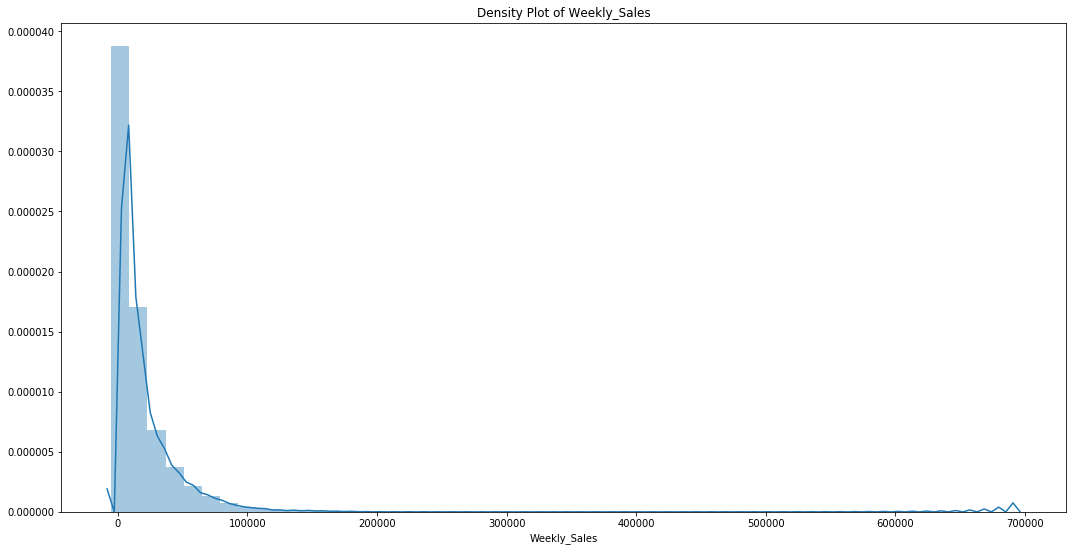

In [16]:
plt.title('Density Plot of Weekly_Sales')
sns.distplot(train_data.Weekly_Sales)

It does not look like normally distributed

In [17]:
train_data.Weekly_Sales.describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

We can see that the mean is much much higher that the median value - indicating that the the distribution is right skewed.

Lets look at the distribution of log scaled weekly_sales

In [18]:
log_weekly_sales = np.log(train_data.Weekly_Sales[train_data.Weekly_Sales>0])

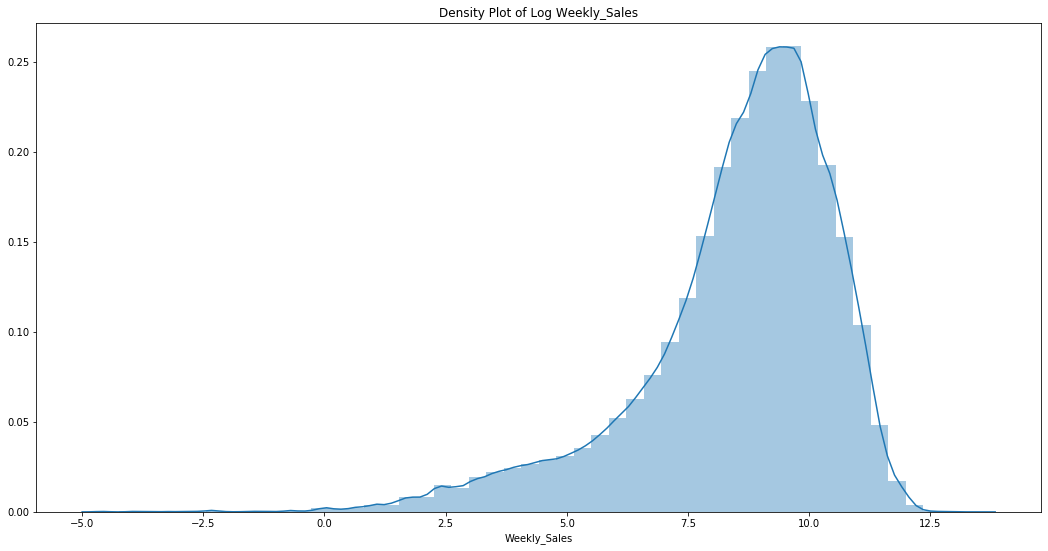

In [19]:
plt.title('Density Plot of Log Weekly_Sales')
sns.distplot(log_weekly_sales)

This looks somewhat normally distributed but there is still a skew to the left. Lets look at the summary statistics.

I would assume that the distribution of `log(weekly_sales)` is (or close enough to being) a normal distribution

In [20]:
log_weekly_sales.describe()

count    420212.000000
mean          8.520815
std           2.049011
min          -4.605170
25%           7.659233
50%           8.943989
75%           9.916960
max          13.448929
Name: Weekly_Sales, dtype: float64

As we can see, the mean lies to the left of the median value

Lets plot the empirical cdf plot of log_weekly_sales and compare it with the cdf of a normal distribution

In [21]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n

    return x, y


In [22]:
norm_dist = np.random.normal(loc=np.mean(log_weekly_sales),scale = np.std(log_weekly_sales),size=len(log_weekly_sales))

In [23]:
x,y = ecdf(log_weekly_sales)
x_norm,y_norm = ecdf(norm_dist)

C:\Users\shahb\AnacondaPython\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\shahb\AnacondaPython\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\shahb\AnacondaPython\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\shahb\AnacondaPython\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\shahb\AnacondaPython\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sh

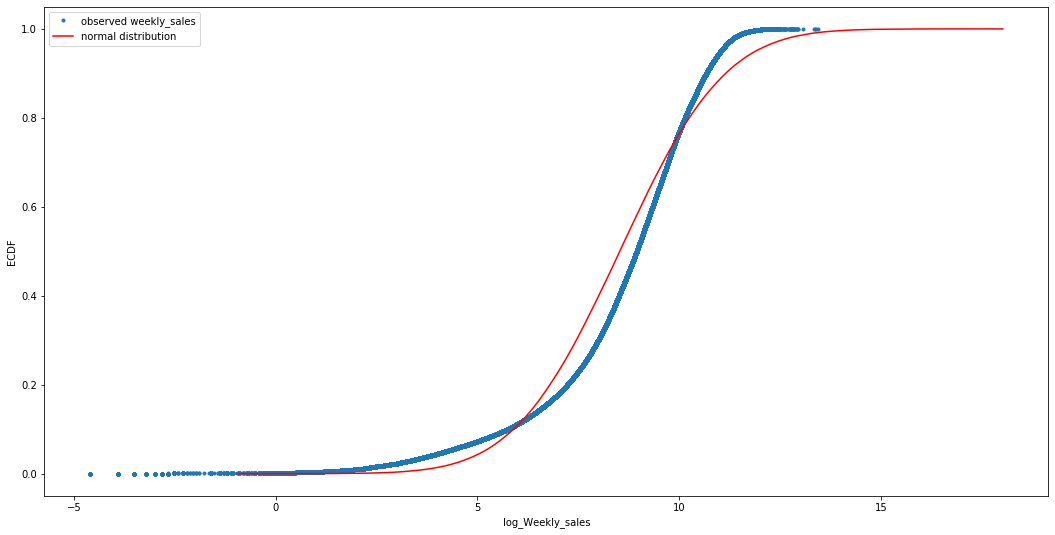

In [24]:
_ = plt.plot(x,y,linestyle='none',marker='.',label='observed weekly_sales')
_ = plt.plot(x_norm,y_norm,color='red',label = 'normal distribution')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('log_Weekly_sales')
_ = plt.legend()

As we can see that even though the distribution looks close to being normal (from the plot), the ecdf shows that they are clearly very different.

Lets apply the shapiro-wilk tests to both weekly_sales and log(weekly_sales). The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

performing the test on all of the data takes a long time so lets sample from the original data.

In [25]:
W,p = shapiro(train_data.Weekly_Sales.sample(5000))
print('Test Statistic: ',round(W,4))
print('p-value: ',p)

Test Statistic:  0.6906
p-value:  0.0


The p-values being 0, we can reject the null hypothesis and conclude that the data did not come from a normal distribution

lets perform the same test on the log_weekly_sales.

In [26]:
W,p = shapiro(log_weekly_sales.sample(5000))
print('Test Statistic: ',round(W,4))
print('p-value: ',p)

Test Statistic:  0.9139
p-value:  0.0


Once again, the p-value is very low, so we cannot assume normality of data.

## Implication of test result

We can see that neither the Weekly_sales nor the log transformed weekly sales are normally distributed. This would mean that in order to use parametric machine learning methods some other transformation would need to be appied in order to enforce normality. Or non parametric methods can be used like Tree based models.

# Testing for stationarity

The sales predicting problem can also be approached by treating it like a time series. Most of the time series models, require that the data be non-stationary. We test for the assumption of stationarity in the series 

In [27]:
store_date_sales = train_data[['Store','Dept','Date','Weekly_Sales']]

In [28]:
store_date_sales.head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,24924.50
1,1,1,2010-02-12,46039.49
2,1,1,2010-02-19,41595.55
3,1,1,2010-02-26,19403.54
4,1,1,2010-03-05,21827.90


Lets aggregate Weekly_sales over time to look at the overall data. Later we will try to test for individual stores and departments

In [29]:
datewise_sales = train.groupby('Date')['Weekly_Sales','IsHoliday'].mean()

In [30]:
datewise_sales.head()

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,16836.121997,False
2010-02-12,16352.056032,True
2010-02-19,16216.658979,False
2010-02-26,14899.549688,False
2010-03-05,15921.015727,False


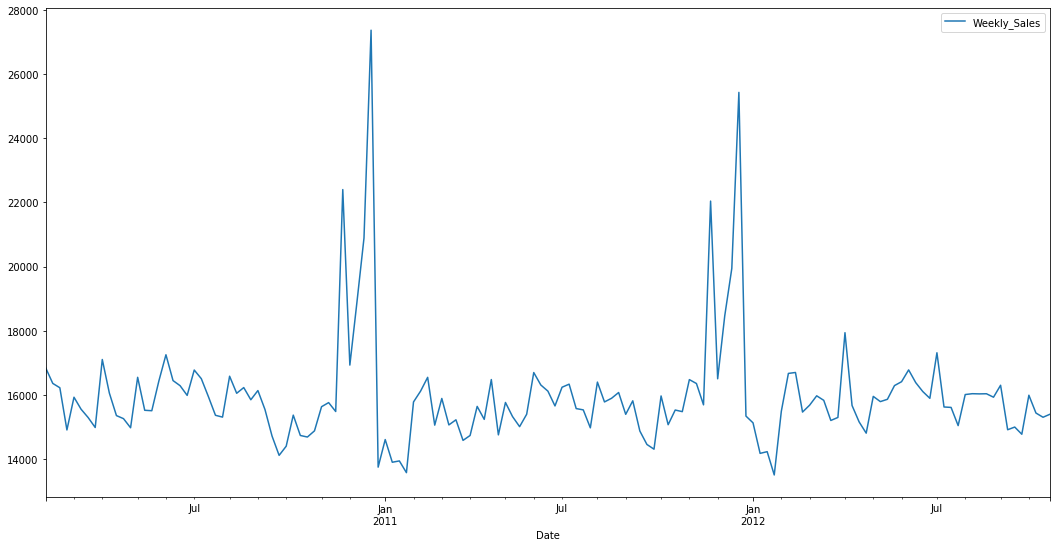

In [31]:
datewise_sales.plot()

In [32]:
?seasonal_decompose

Object `seasonal_decompose` not found.


In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = np.log(datewise_sales['Weekly_Sales'])
result = seasonal_decompose(series, model='additive',two_sided=False,extrapolate_trend='freq',freq=7)

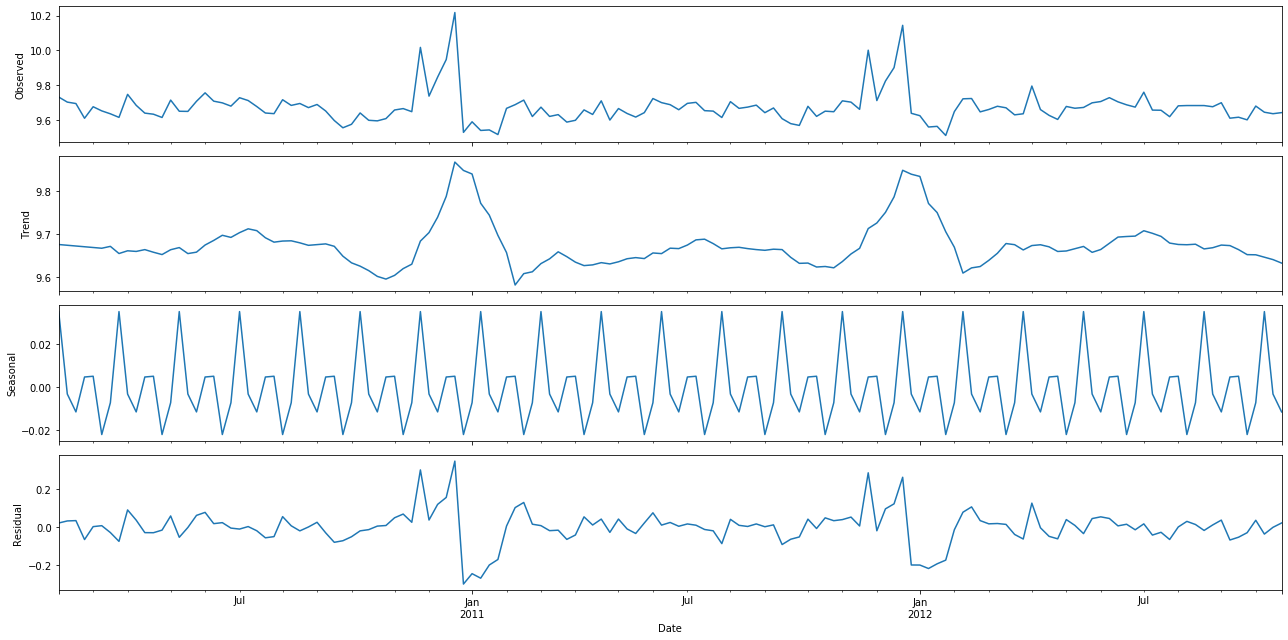

In [34]:
result.plot();

Decomposed series shows that the observed series is goverened majorly by the trend which spikes during the months of Dec - Jan. We also see that the highest residual values are during that period as well. Other than that we notice an intra monthly seasonal trend.

In [34]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

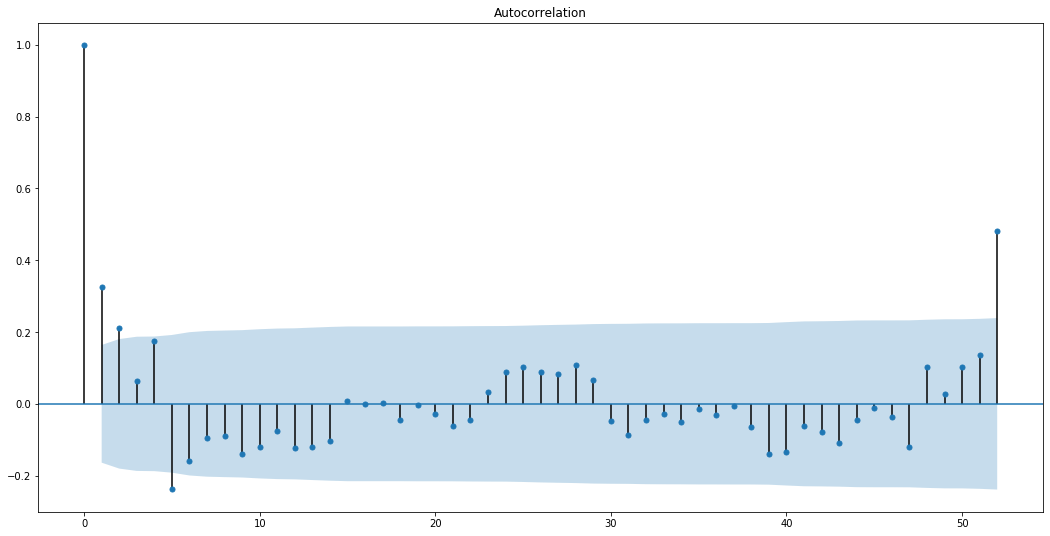

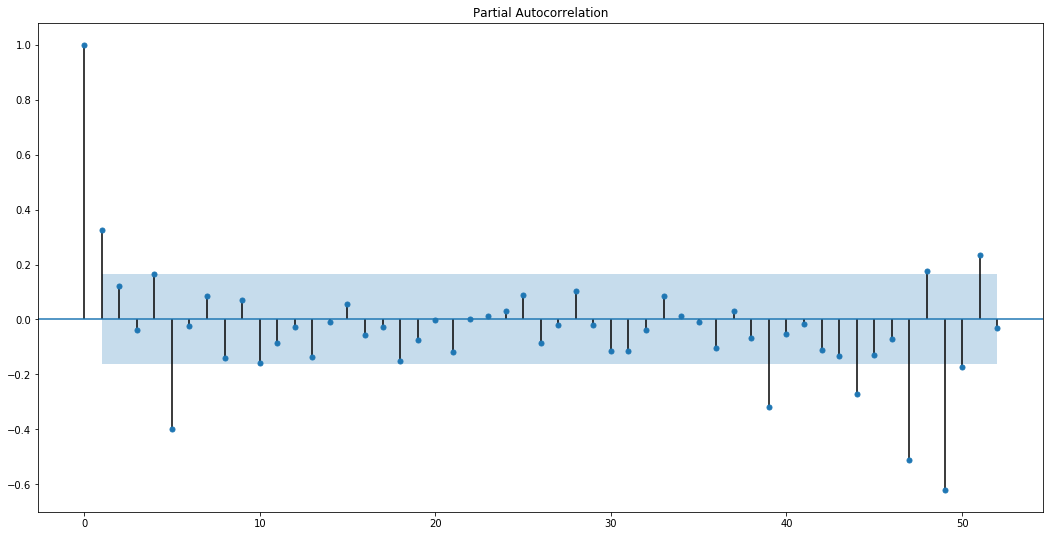

In [35]:
plot_acf(datewise_sales.Weekly_Sales.tolist(),lags=52);
plot_pacf(datewise_sales.Weekly_Sales.tolist(),lags = 52);

Looking at the Autocorrelation plot, we can see that the past sales lag of 1-14 weeks,week 26-29, and week 48-52are most correlated with the current weekly sales. I will create features according to these.  

# CPI - Weekly_Sales

In [61]:
train_data['CPI_cat'] = np.where(train_data.CPI<160,'LowCPI','HighCPI')

In [70]:
train_data.groupby(['CPI_cat'],observed=False)['Weekly_Sales'].agg(['describe']).reset_index()

CPI_cat  describe                                                          \
               count          mean           std      min       25%      50%   
0  HighCPI  213679.0  15585.283065  22785.414822 -1750.00  1953.510  7046.46   
1   LowCPI  207891.0  16388.257727  22627.466173 -4988.94  2238.285  8220.88   

                         
         75%        max  
0  19214.105  474330.10  
1  21223.620  693099.36

Text(0.5, 1.0, 'Weekly_Sales VS Date - Split over 2 CPI Categories')

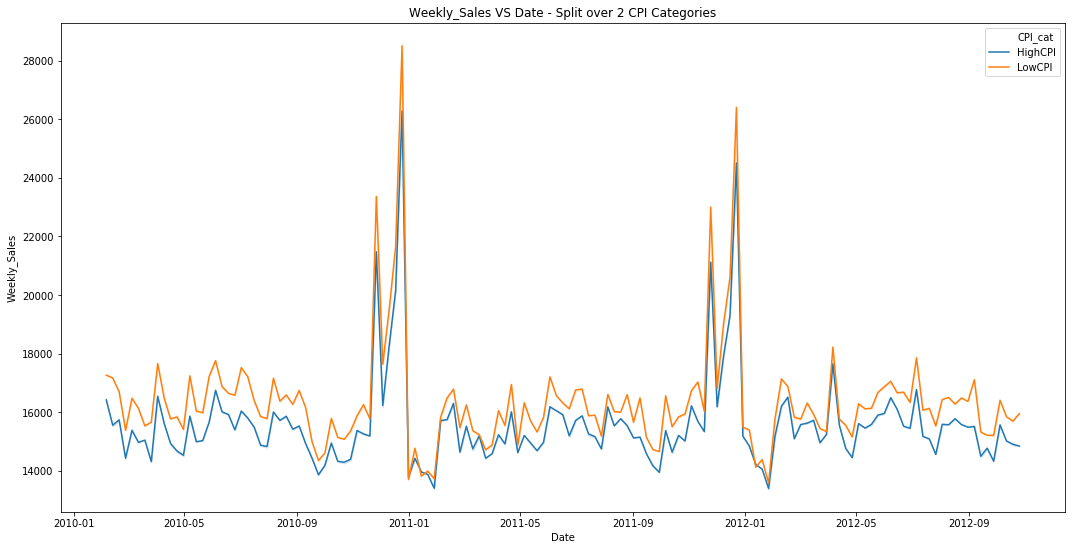

In [71]:
sns.lineplot(x='Date',y='Weekly_Sales',hue='CPI_cat',data = train_data,ci=False).set_title('Weekly_Sales VS Date - Split over 2 CPI Categories')

We can see that the LowCPI Sales are consistently higher than HighCPI store. We will try to conduct a statistical test in order to ascertain our observation

In [ ]:
sns.distplot(train_data.)

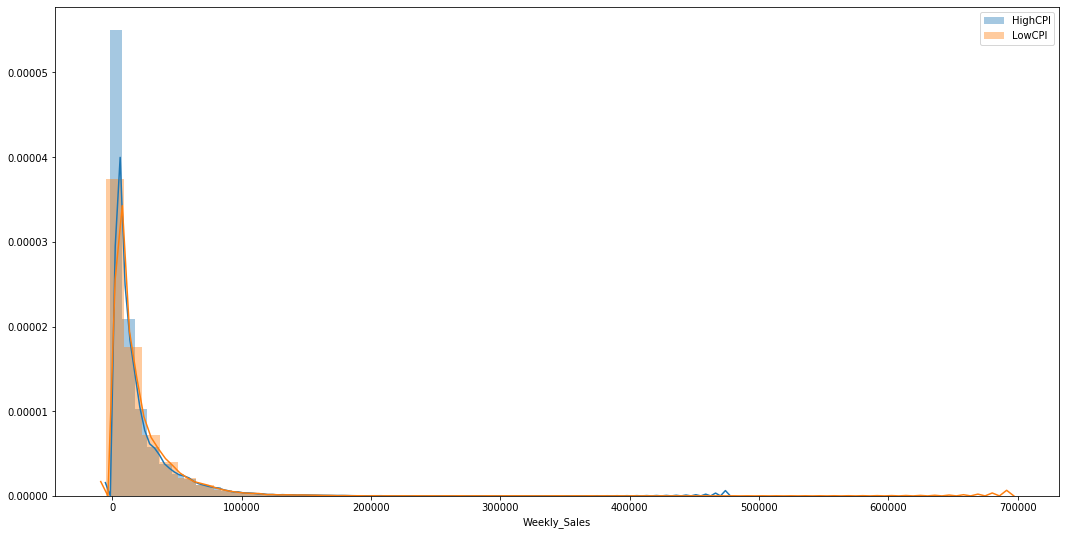

In [106]:
sns.distplot((train_data[train_data.CPI_cat=='HighCPI'].Weekly_Sales),label='HighCPI')
sns.distplot((train_data[train_data.CPI_cat=='LowCPI'].Weekly_Sales),label='LowCPI')
plt.legend()

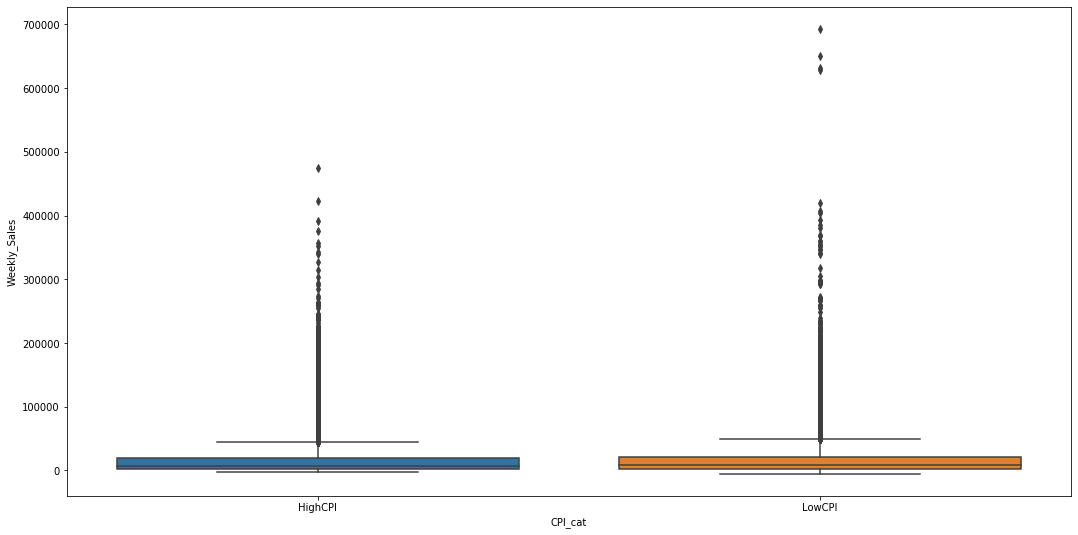

In [114]:
sns.boxplot(y='Weekly_Sales',x='CPI_cat',data=train_data)

It is not possible to notice the difference between the means of the categories in question.

In [107]:
from scipy.stats import t,ttest_ind

H0 : No difference in means
HA : Significant difference in means

In [127]:
stat,p = ttest_ind(train_data[train_data.CPI_cat=='HighCPI'].Weekly_Sales,
          train_data[train_data.CPI_cat=='LowCPI'].Weekly_Sales,equal_var=True)

In [128]:
p

1.705396374374582e-30

p-value is very very small which should conclude that the means arent equal and thus CPI_Cat should be a good feature to predict the weekly_sales